In [1]:
import numpy as np
import json
from livecell_tracker.core import (
    SingleCellTrajectory,
    SingleCellStatic,
    SingleCellTrajectoryCollection,
)
from livecell_tracker.segment.detectron_utils import (
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
    segment_images_by_detectron,
    segment_single_img_by_detectron_wrapper,
)
from livecell_tracker.core.datasets import LiveCellImageDataset
from livecell_tracker.preprocess.utils import (
    overlay,
    enhance_contrast,
    normalize_img_to_uint8,
)
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pathlib import Path
import pandas as pd

## Convert Labelme Json to COCO Json

run the following code once for generating coco json
```
import livecell_tracker.segment
import livecell_tracker.annotation
import livecell_tracker.annotation.labelme2coco
import os
labelme_json_folder = r"""../datasets/a549_ccnn/annotation_data"""
dataset_folder_path = r"""../datasets/a549_ccnn/original_data"""
export_dir = "./notebook_results/correction_cnn_v0.0.0/"
os.makedirs(export_dir, exist_ok=True)
livecell_tracker.annotation.labelme2coco.convert(
    labelme_json_folder,
    export_dir,
    train_split_rate=0.9,
    dataset_folder_path=dataset_folder_path,
    # is_image_in_json_folder=True,
    image_file_ext="tif",
    # image_file_ext="png",
)
```

## Load COCO into SingleCell Objects

In [2]:
from pycocotools.coco import COCO

coco_data = COCO("../datasets/a549_ccnn/a549_ccnn_coco_v0.0.0/train.json")
out_dir = Path("./notebook_results/a549_ccp_vim/train_data_v6/")

coco_data.anns.keys(), coco_data.anns[1].keys(), coco_data.anns[1]["segmentation"][0][
    :5
]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [3]:
coco_data.imgs.keys(), coco_data.imgs[1].keys(), coco_data.imgs[1]["file_name"],


(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 dict_keys(['height', 'width', 'id', 'file_name']),
 '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY4_DIC_tile7_DIC-FITC.tif')

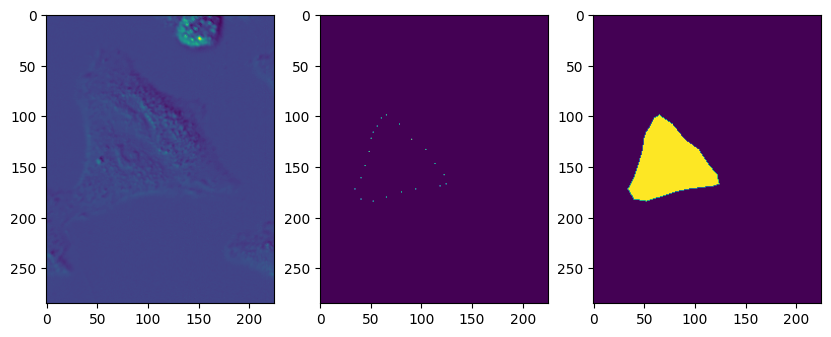

In [4]:
from typing import List

from livecell_tracker.annotation.coco_utils import coco_to_sc

single_cells = coco_to_sc(coco_data)


# for testing
single_cells = single_cells[:20]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
cell_id = 10
axes[0].imshow(single_cells[cell_id].get_img_crop(padding=100))
axes[1].imshow(single_cells[cell_id].get_contour_mask_closed_form(padding=100))
axes[2].imshow(single_cells[cell_id].get_contour_mask(padding=100))


In [5]:
len(single_cells)

20

save a list of single cell objects

In [6]:
SingleCellStatic.write_single_cells_json(
    single_cells, "../datasets/a549_ccnn/single_cells.json"
)


In [7]:
contour_mask = single_cells[cell_id].get_contour_mask(padding=100)
contour_mask.astype(np.uint8)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

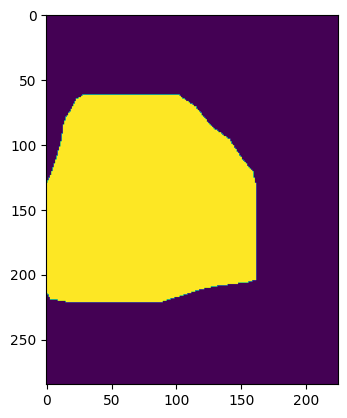

In [8]:
import cv2 as cv
from livecell_tracker.preprocess.utils import dilate_or_erode_mask

plt.imshow(dilate_or_erode_mask(contour_mask.astype(np.uint8), 1))


In [9]:
sample_sc = single_cells[cell_id]
sample_sc.meta

{'img_id': 7,
 'path': '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY1_DIC_tile8_DIC-FITC.tif'}

In [10]:
import glob

raw_img_dataset = sample_sc.img_dataset
seg_data_dir = "../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11"
seg_paths = glob.glob(os.path.join(seg_data_dir, "*.png"))
print("sample seg paths:", seg_paths[:2])
matched_time2seg = {}
# for time, img_path in raw_img_dataset.time2url.items():
#     substr = os.path.basename(img_path).split(".")[0]
#     print("substr:", substr)
#     for seg_path
#     break
corrected_indices = []
for seg_path in seg_paths:
    substr = os.path.basename(seg_path).split(".")[0] # get rid of extension
    substr = substr[4:]  # get rid of seg_ prefix
    img, path, index = raw_img_dataset.get_img_by_url(
        substr, return_path_and_time=True, ignore_missing=True
    )
    if path is None:
        print("skip due to substr not found:", substr)
        continue
    matched_time2seg[index] = seg_path

seg_data = LiveCellImageDataset(time2url=matched_time2seg, ext="png")
sample_sc.mask_dataset = seg_data
assert len(seg_data) == len(raw_img_dataset)


sample seg paths: ['../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY2_DIC_tile8_DIC-FITC.png', '../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY4_DIC_tile0_DIC-FITC.png']
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY1_DIC_tile1_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY2_DIC_tile4_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY4_DIC_tile1_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY1_DIC_tile4_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY4_DIC_tile2_DIC-FITC
skip due to substr not fo

## Generate Synthetic Undersegmentation data

<AxesSubplot: >

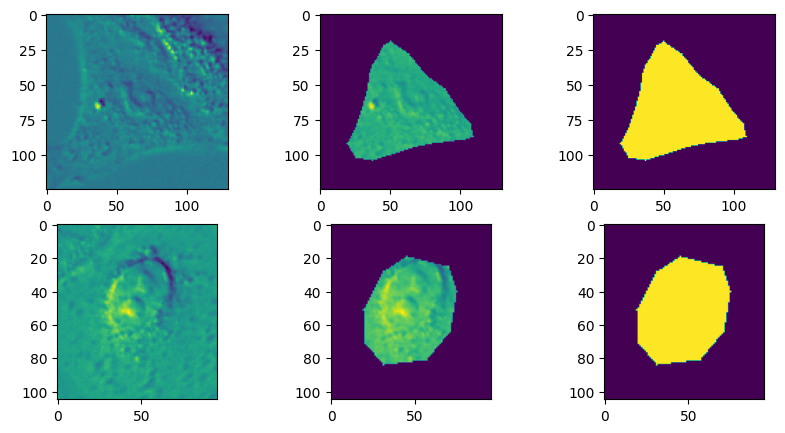

In [11]:
sc1 = single_cells[10]
sc2 = single_cells[1]

padding=20
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
sc1.show(padding=padding, ax=axes[0][0])
sc1.show_contour_img(padding=padding, ax=axes[0][1])
sc1.show_contour_mask(padding=padding, ax=axes[0][2])
sc2.show(padding=padding, ax=axes[1][0])
sc2.show_contour_img(padding=padding, ax=axes[1][1])
sc2.show_contour_mask(padding=padding, ax=axes[1][2])

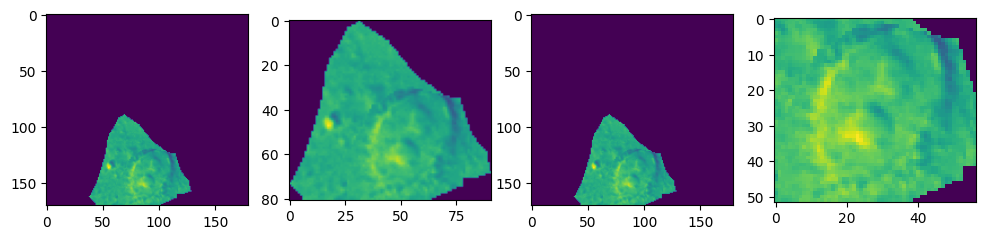

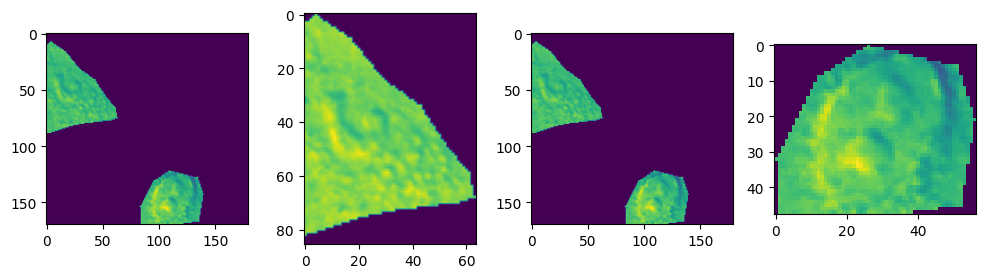

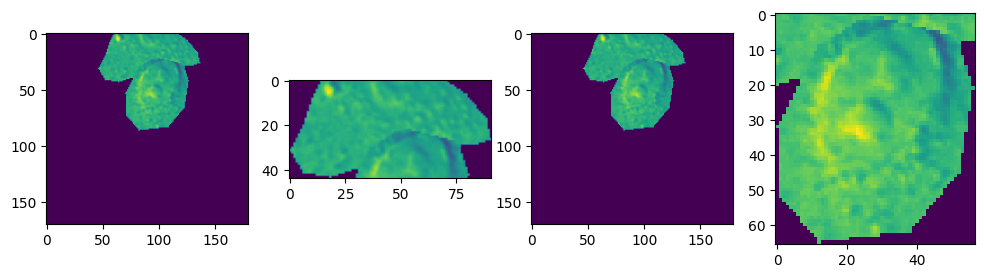

In [61]:
from livecell_tracker.core.datasets import SingleImageDataset


def check_contour_in_boundary(contour, boundary):
    return np.all(contour >= 0) and np.all(contour < boundary)


def adjust_contour_to_bounds(contour, bounds):
    if not check_contour_in_boundary(contour, bounds):
        contour = contour.copy()
        contour[contour < 0] = 0
        contour = np.where(contour >= bounds, bounds - 1, contour)
    return contour

def shift_contour_randomly(sc_center, contour, bounds):
    random_center = np.random.randint(low=0, high=bounds, size=2)
    shift = random_center - sc_center
    shift = shift.astype(int)
    contour_shifted = contour + shift
    return random_center, contour_shifted, shift

def compute_two_contours_min_distance(contour1, contour2):
    min_dist = np.inf
    for p1 in contour1:
        for p2 in contour2:
            dist = np.linalg.norm(p1 - p2)
            if dist < min_dist:
                min_dist = dist
    return min_dist

def combine_sc_monte_carlo(sc1, sc2, min_dist=10, max_dist=100, n=10, bg_img=None, bg_scale=2.0):
    
    def _gen_empty_bg_img():
        sc1_shape = sc1.get_img_crop().shape
        sc2_shape = sc2.get_img_crop().shape
        bg_shape = np.array([max(sc1_shape[0], sc2_shape[0]), max(sc1_shape[1], sc2_shape[1])])
        bg_shape = (bg_shape * bg_scale).astype(int)
        bg_img = np.zeros(shape=bg_shape)
        return bg_img
    
    if bg_img is None:
        bg_img = _gen_empty_bg_img()

    bg_shape = np.array(bg_img.shape)
    new_img = bg_img.copy()

    def _add_sc_to_img_helper(sc, new_img, new_sc_mask, shift, in_place=False):
        if not in_place:
            new_img = new_img.copy()
        sc_ori_space_pixel_xy_arr = np.array(new_sc_mask.nonzero()).T - shift
        sc_ori_space_pixel_xy_arr[sc_ori_space_pixel_xy_arr < 0] = 0
        new_img[new_sc_mask] = sc.get_contour_img()[sc_ori_space_pixel_xy_arr[:, 0], sc_ori_space_pixel_xy_arr[:, 1]]
        return new_img

    def add_sc_to_img(sc, new_img, in_place=False):
        sc_prop = sc.compute_regionprops()
        sc_contour_coords = sc.get_contour_coords_on_crop().astype(int)
        sc_new_center, sc_new_contour, shift = shift_contour_randomly(sc_prop.centroid, sc_contour_coords, bounds=bg_shape)
        sc_new_contour = adjust_contour_to_bounds(sc_new_contour, bg_shape)
        new_sc_mask = SingleCellStatic.gen_contour_mask(sc_new_contour, bg_img, bbox=None)
        new_sc2_mask = new_sc_mask > 0 # convert to bool
        new_img = _add_sc_to_img_helper(sc, new_img, new_sc_mask, shift, in_place=in_place)
        return new_img, sc_new_contour, shift

    _, sc1_new_contour, shift1 = add_sc_to_img(sc1, new_img, in_place=True)
    _, sc2_new_contour, shift2 = add_sc_to_img(sc2, new_img, in_place=True)
    new_sc1 = SingleCellStatic(timeframe=SingleImageDataset.DEFAULT_TIME, contour=sc1_new_contour, img_dataset=SingleImageDataset(new_img))
    new_sc2 = SingleCellStatic(timeframe=SingleImageDataset.DEFAULT_TIME, contour=sc2_new_contour, img_dataset=SingleImageDataset(new_img))
    min_dist = compute_two_contours_min_distance(sc1_new_contour, sc2_new_contour)
    return new_sc1, new_sc2

# has_overlap = np.any(new_sc1_mask & new_sc2_mask)
# print(has_overlap)
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# ax = axes[0][0]
# ax.imshow(new_sc1_mask | new_sc2_mask)
# ax = axes[0][1]
# ax.imshow(new_img)
bg_scale = 3.0

def check_combined_sc_result(sc1, sc2):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    sc1.show_whole_img(ax=axes[0])
    sc1.show(ax=axes[1])
    sc2.show_whole_img(ax=axes[2])
    sc2.show(ax=axes[3])
    plt.show()

for i in range(3):
    new_sc1, new_sc2 = combine_sc_monte_carlo(sc1, sc2, bg_img=None)
    check_combined_sc_result(new_sc1, new_sc2)

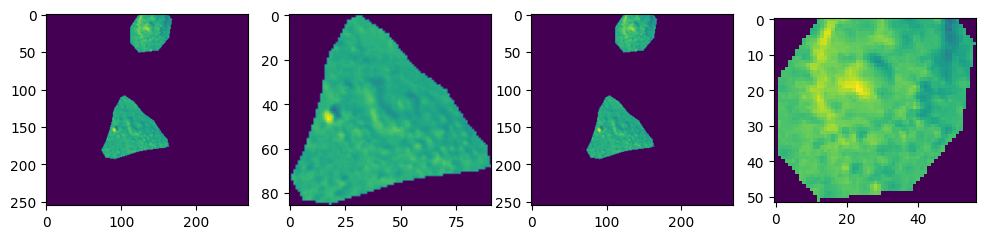

In [14]:
def generate_underseg_cases(scs):
    pass

## Combine data.csv files generated in each subfolder

In [15]:
dataframes = []
for subdir in out_dir.iterdir():
    if subdir.is_dir():
        data_path = subdir / "data.csv"
        dataframe = pd.read_csv(data_path)
        dataframe["subdir"] = subdir.name
        dataframes.append(dataframe)
combined_dataframe = pd.concat(dataframes)
combined_dataframe.to_csv(out_dir / "train_data.csv", index=False)

In [16]:
len(combined_dataframe)

60